# Atendimentos AS Trindade 2023 (A)

## Importando e Tratando Base Feegow

In [1]:
import pandas as pd

# Importando a base de tempo de espera pré-tratativa CX
df_a_completo = pd.read_csv('/home/lucasmateus/dbt-projects/projetos_lucas/cx/tempo_medio_espera/as trindade/tempo_espera_atendimento_trindade_2023.csv')

In [2]:
# Filter data from July 1st onwards (inclusive)
df_a_completo['dt_agendamento'] = df_a_completo['dt_agendamento'].str.strip("'")
df_a_completo['dt_agendamento'] = pd.to_datetime(df_a_completo['dt_agendamento'], format='%Y-%m-%d')
df_a_completo = df_a_completo[df_a_completo['dt_agendamento'] >= '2023-07-01']
df_a_completo.head(1)

,id_agendamento,dt_agendamento,id_unidade,unidade,nm_profissional,hora,nome_status,status_id,nm_especialidade,fila_status,duracao_tempo
0,869028343,2023-12-29,19854,AmorSaúde Trindade,Cymara Cristina De Lima Marques Mendes,14:40:38.000,Atendido,3,Fisioterapia,3,NaN


In [3]:
df_a_completo.dtypes

id_agendamento               int64
dt_agendamento      datetime64[ns]
id_unidade                   int64
unidade                     object
nm_profissional             object
hora                        object
nome_status                 object
status_id                    int64
nm_especialidade            object
fila_status                  int64
duracao_tempo               object
dtype: object

In [4]:
df_a = df_a_completo.dropna(subset=['duracao_tempo'])

In [5]:
df_a.head(1)

,id_agendamento,dt_agendamento,id_unidade,unidade,nm_profissional,hora,nome_status,status_id,nm_especialidade,fila_status,duracao_tempo
1,869028343,2023-12-29,19854,AmorSaúde Trindade,Cymara Cristina De Lima Marques Mendes,13:36:35.000,Em atendimento,2,Fisioterapia,2,0 01:04:03.000


In [6]:
# Function to convert time duration string to seconds
def time_str_to_seconds(time_str):
    # Check if the value starts with a hyphen ("-")
    if time_str.startswith('-'):
        return None  # Return None for negative values
    # Check if there is an extra leading zero
    elif time_str.startswith('0 '):
        # Remove the extra leading zero if present
        time_str = time_str[2:]  # Remove the extra leading zero
    
    # Remove milliseconds from the time string
    time_str = time_str.split('.')[0]
    
    # Split the time string into hours, minutes, and seconds
    parts = time_str.split(':')
    
    # Convert the parts to integers
    hours, minutes, seconds = map(int, parts)
    
    # Calculate the total seconds
    total_seconds = hours * 3600 + minutes * 60 + seconds
    
    return total_seconds

# Convert the duracao_tempo column to seconds
df_a['duracao_tempo_seconds'] = df_a['duracao_tempo'].apply(time_str_to_seconds)

# Drop rows with negative values
df_a = df_a.dropna(subset=['duracao_tempo_seconds'])


/tmp/ipykernel_779898/568554916.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a['duracao_tempo_seconds'] = df_a['duracao_tempo'].apply(time_str_to_seconds)


In [7]:
# Create a new column duracao_tempo_minutes by dividing duracao_tempo_seconds by 60
df_a['duracao_tempo_minutes'] = df_a['duracao_tempo_seconds'] / 60

/tmp/ipykernel_779898/3280060836.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a['duracao_tempo_minutes'] = df_a['duracao_tempo_seconds'] / 60


In [8]:
df_a.head(1)

,id_agendamento,dt_agendamento,id_unidade,unidade,nm_profissional,hora,nome_status,status_id,nm_especialidade,fila_status,duracao_tempo,duracao_tempo_seconds,duracao_tempo_minutes
1,869028343,2023-12-29,19854,AmorSaúde Trindade,Cymara Cristina De Lima Marques Mendes,13:36:35.000,Em atendimento,2,Fisioterapia,2,0 01:04:03.000,3843.0,64.05


In [9]:
# Filter rows where status_id is 4 (for waiting)
df_a_espera = df_a[df_a['status_id'] == 4]

# Filter rows where status_id is 2 (for service)
df_a_atendimento = df_a[df_a['status_id'] == 2]

In [10]:
df_a_espera.head(1)

,id_agendamento,dt_agendamento,id_unidade,unidade,nm_profissional,hora,nome_status,status_id,nm_especialidade,fila_status,duracao_tempo,duracao_tempo_seconds,duracao_tempo_minutes
2,869028343,2023-12-29,19854,AmorSaúde Trindade,Cymara Cristina De Lima Marques Mendes,13:26:41.000,Aguardando,4,Fisioterapia,1,0 00:09:54.000,594.0,9.9


In [11]:
df_a_atendimento.head(1)

,id_agendamento,dt_agendamento,id_unidade,unidade,nm_profissional,hora,nome_status,status_id,nm_especialidade,fila_status,duracao_tempo,duracao_tempo_seconds,duracao_tempo_minutes
1,869028343,2023-12-29,19854,AmorSaúde Trindade,Cymara Cristina De Lima Marques Mendes,13:36:35.000,Em atendimento,2,Fisioterapia,2,0 01:04:03.000,3843.0,64.05


## Análise Exploratória do Tempo de Espera

In [12]:
# Importanto bibliotecas gráficas
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for seaborn plots
sns.set(style="white")
sns.despine(top=True, right=True, left=True, bottom=True)

<Figure size 640x480 with 0 Axes>

In [13]:
# Descriptive analysis and boxplot for df_a_espera
print("Descriptive statistics for df_a_espera:")
descriptive_stats_espera = df_a_espera['duracao_tempo_minutes'].describe().round().astype(int)
print(descriptive_stats_espera)


Descriptive statistics for df_a_espera:
count    6322
mean       40
std        33
min         0
25%        17
50%        34
75%        55
max       504
Name: duracao_tempo_minutes, dtype: int64


In [49]:
print("\nDescriptive statistics for df_a_espera:")
descriptive_stats_espera = df_a_espera['duracao_tempo_minutes'].describe().astype(int)

# Convert Series to DataFrame
descriptive_stats_df = descriptive_stats_espera.to_frame().reset_index()

# Optional: Rename columns for clarity
descriptive_stats_df.columns = ['Statistic', 'Value']

descriptive_stats_df


Descriptive statistics for df_a_espera:


,Statistic,Value
0,count,6322
1,mean,40
2,std,33
3,min,0
4,25%,16
5,50%,33
6,75%,55
7,max,503


In [15]:
# Descriptive analysis segmented by nm_especialidade for df_a_espera
print("\nDescriptive statistics for df_a_espera segmented by nm_especialidade:")
descriptive_stats_espera_segmented = df_a_espera.groupby('nm_especialidade')['duracao_tempo_minutes'].describe().round().astype(int)


# Sort by the median (50th percentile)
descriptive_stats_espera_segmented_sorted = descriptive_stats_espera_segmented.sort_values(by='50%', ascending=True)
descriptive_stats_espera_segmented_sorted


Descriptive statistics for df_a_espera segmented by nm_especialidade:


,count,mean,std,min,25%,50%,75%,max
nm_especialidade,,,,,,,,
Pneumologia,57,19,31,1,5,12,18,217
Fisioterapia,155,26,24,1,6,20,38,122
Gastroenterologia,16,21,12,1,17,20,32,40
Ginecologia e Obstetrícia,811,32,33,0,10,22,45,454
Urologia,146,28,31,0,8,23,35,225
Pediatria,224,35,36,1,15,25,44,299
Ortopedia e Traumatologia,351,34,33,0,9,25,47,239
Cardiologia,364,32,28,1,16,27,41,272
Clinica Médica,1188,33,27,0,16,27,44,274


## Análise Exploratória do Tempo de Atendimento

In [16]:
# Descriptive analysis and boxplot for df_a_atendimento
print("\nDescriptive statistics for df_a_atendimento:")
descriptive_stats_atendimento = df_a_atendimento['duracao_tempo_minutes'].describe().round(1)#.astype(int)
print(descriptive_stats_atendimento)


Descriptive statistics for df_a_atendimento:
count    6399.0
mean        9.5
std        11.9
min         0.0
25%         3.9
50%         6.9
75%        11.4
max       475.0
Name: duracao_tempo_minutes, dtype: float64


In [17]:
print("\nDescriptive statistics for df_a_atendimento:")
descriptive_stats_atendimento = df_a_atendimento['duracao_tempo_minutes'].describe().round().astype(int)

# Convert Series to DataFrame
descriptive_stats_df = descriptive_stats_atendimento.to_frame().reset_index()

# Optional: Rename columns for clarity
descriptive_stats_df.columns = ['Statistic', 'Value']

descriptive_stats_df


Descriptive statistics for df_a_atendimento:


,Statistic,Value
0,count,6399
1,mean,9
2,std,12
3,min,0
4,25%,4
5,50%,7
6,75%,11
7,max,475


In [18]:
# Descriptive analysis segmented by nm_especialidade for df_a_atendimento
print("\nDescriptive statistics for df_a_atendimento segmented by nm_especialidade:")
descriptive_stats_atendimento_segmented = df_a_atendimento.groupby('nm_especialidade')['duracao_tempo_minutes'].describe().round().astype(int)

# Sort by the median (50th percentile)
descriptive_stats_atendimento_segmented_sorted = descriptive_stats_atendimento_segmented.sort_values(by='50%', ascending=True)
descriptive_stats_atendimento_segmented_sorted


Descriptive statistics for df_a_atendimento segmented by nm_especialidade:


,count,mean,std,min,25%,50%,75%,max
nm_especialidade,,,,,,,,
Otorrinolaringologia,312,4,3,1,3,3,5,34
Cardiologia,364,6,25,0,2,4,6,475
Oftalmologia,615,5,5,0,3,4,6,51
Ginecologia e Obstetrícia,811,6,6,0,2,5,8,48
Urologia,150,8,10,2,4,6,8,110
Endocrinologia,229,7,11,1,4,6,8,137
Psiquiatria,461,10,10,0,5,7,12,181
Clinica Médica,1196,8,7,0,4,7,10,174
Dermatologia,391,9,9,0,5,8,11,102


# Atendimento AS Trindade 2024 (B)

## Importando e Tratando Base Feegow

In [19]:
# Importing the CX pre-treatment waiting time database
df_b_completo = pd.read_csv('/home/lucasmateus/dbt-projects/projetos_lucas/cx/tempo_medio_espera/as trindade/tempo_espera_atendimento_trindade_2024.csv')

In [20]:
df_b_completo.head(1)

,id_agendamento,dt_agendamento,id_unidade,unidade,nm_profissional,hora,nome_status,status_id,nm_especialidade,fila_status,duracao_tempo
0,877427918,'2024-03-30',19854,AmorSaúde Trindade,Ramon Girotto,10:19:21.000,Atendido,3,Clinica Médica,3,NaN


In [21]:
df_b = df_b_completo.dropna(subset=['duracao_tempo'])

In [22]:
df_b.head(1)

,id_agendamento,dt_agendamento,id_unidade,unidade,nm_profissional,hora,nome_status,status_id,nm_especialidade,fila_status,duracao_tempo
1,877427918,'2024-03-30',19854,AmorSaúde Trindade,Ramon Girotto,10:07:24.000,Em atendimento,2,Clinica Médica,2,0 00:11:57.000


In [23]:
# Convert the duracao_tempo column to seconds
df_b['duracao_tempo_seconds'] = df_b['duracao_tempo'].apply(time_str_to_seconds)

/tmp/ipykernel_779898/1189470043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b['duracao_tempo_seconds'] = df_b['duracao_tempo'].apply(time_str_to_seconds)


In [24]:
# Drop rows with negative values
df_b = df_b.dropna(subset=['duracao_tempo_seconds'])

In [25]:
# Create a new column duracao_tempo_minutes by dividing duracao_tempo_seconds by 60
df_b['duracao_tempo_minutes'] = df_b['duracao_tempo_seconds'] / 60

/tmp/ipykernel_779898/56378167.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b['duracao_tempo_minutes'] = df_b['duracao_tempo_seconds'] / 60


In [26]:
df_b.head(1)

,id_agendamento,dt_agendamento,id_unidade,unidade,nm_profissional,hora,nome_status,status_id,nm_especialidade,fila_status,duracao_tempo,duracao_tempo_seconds,duracao_tempo_minutes
1,877427918,'2024-03-30',19854,AmorSaúde Trindade,Ramon Girotto,10:07:24.000,Em atendimento,2,Clinica Médica,2,0 00:11:57.000,717.0,11.95


In [27]:
# Filter rows where status_id is 4 (for waiting)
df_b_espera = df_b[df_b['status_id'] == 4]

In [28]:
# Filter rows where status_id is 2 (for service)
df_b_atendimento = df_b[df_b['status_id'] == 2]


In [29]:
df_b_espera.head(1)

,id_agendamento,dt_agendamento,id_unidade,unidade,nm_profissional,hora,nome_status,status_id,nm_especialidade,fila_status,duracao_tempo,duracao_tempo_seconds,duracao_tempo_minutes
2,877427918,'2024-03-30',19854,AmorSaúde Trindade,Ramon Girotto,10:05:22.000,Aguardando,4,Clinica Médica,1,0 00:02:02.000,122.0,2.033333


In [30]:
df_b_atendimento.head(1)

,id_agendamento,dt_agendamento,id_unidade,unidade,nm_profissional,hora,nome_status,status_id,nm_especialidade,fila_status,duracao_tempo,duracao_tempo_seconds,duracao_tempo_minutes
1,877427918,'2024-03-30',19854,AmorSaúde Trindade,Ramon Girotto,10:07:24.000,Em atendimento,2,Clinica Médica,2,0 00:11:57.000,717.0,11.95


## Análise Exploratória do Tempo de Espera

In [31]:
# Descriptive analysis and boxplot for df_b_espera
print("Descriptive statistics for df_b_espera:")
descriptive_stats_espera = df_b_espera['duracao_tempo_minutes'].describe().astype(int)
print(descriptive_stats_espera)

Descriptive statistics for df_b_espera:
count    3303
mean       36
std        30
min         0
25%        14
50%        29
75%        50
max       290
Name: duracao_tempo_minutes, dtype: int64


In [32]:
print("\nDescriptive statistics for df_b_espera:")
descriptive_stats_espera = df_b_espera['duracao_tempo_minutes'].describe().round().astype(int)

# Convert Series to DataFrame
descriptive_stats_df = descriptive_stats_espera.to_frame().reset_index()

# Optional: Rename columns for clarity
descriptive_stats_df.columns = ['Statistic', 'Value']

descriptive_stats_df


Descriptive statistics for df_b_espera:


,Statistic,Value
0,count,3303
1,mean,37
2,std,30
3,min,0
4,25%,14
5,50%,30
6,75%,51
7,max,290


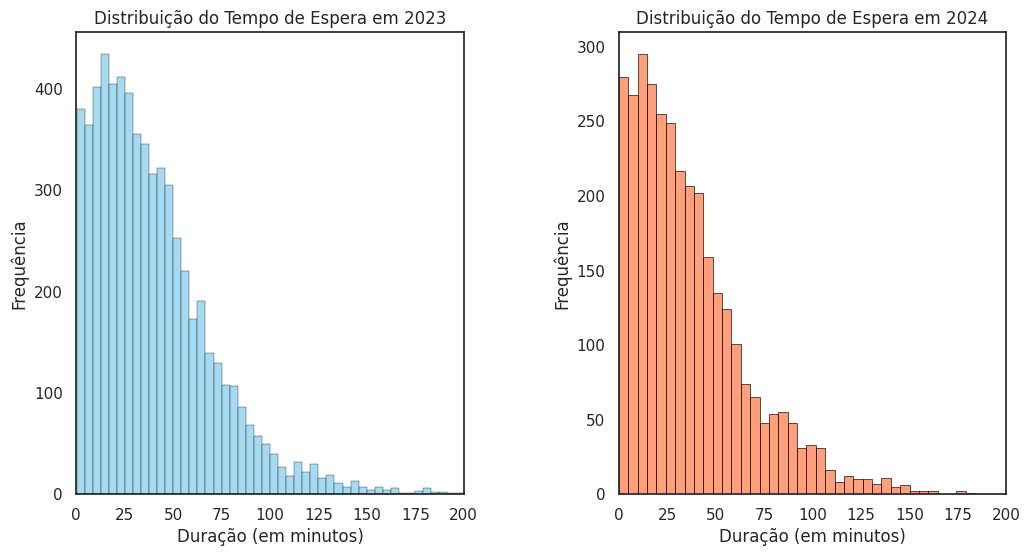

In [33]:
# Assuming your dataframes are named df_a_espera and df_b_espera

# Set the background style (optional)
plt.figure(figsize=(12, 6))  # Adjust figure size for side-by-side plots
sns.set_style("white")  # Optional: Set white background (no grid)

# Plot histograms side-by-side using subplots (similar to method 1 from previous response)
plt.subplot(1, 2, 1)  # First subplot for df_a_espera

sns.histplot(data=df_a_espera, x='duracao_tempo_minutes', color='skyblue', edgecolor='black')
plt.title('Distribuição do Tempo de Espera em 2023')
plt.xlabel('Duração (em minutos)')
plt.ylabel('Frequência')
plt.xlim(0, 200)  # Adjust x-axis limits based on your data

# Remove gridlines (not needed with white style)
plt.grid(False)

plt.subplot(1, 2, 2)  # Second subplot for df_b_espera

sns.histplot(data=df_b_espera, x='duracao_tempo_minutes', color='coral', edgecolor='black')
plt.title('Distribuição do Tempo de Espera em 2024')
plt.xlabel('Duração (em minutos)')
plt.ylabel('Frequência')
plt.xlim(0, 200)  # Adjust x-axis limits based on your data

# Optional: Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)  # Adjust spacing as needed

# Save the figure with a descriptive name
plt.savefig('histograma_espera_trindade.png')  # Saves as PNG by default

plt.show()  # Optional: Display the plot before saving

In [34]:
# Descriptive analysis segmented by nm_especialidade for df_b_espera
print("\nDescriptive statistics for df_b_espera segmented by nm_especialidade:")
descriptive_stats_espera_segmented = df_b_espera.groupby('nm_especialidade')['duracao_tempo_minutes'].describe().round().astype(int)


# Sort by the median (50th percentile)
descriptive_stats_espera_segmented_sorted = descriptive_stats_espera_segmented.sort_values(by='50%', ascending=True)
descriptive_stats_espera_segmented_sorted


Descriptive statistics for df_b_espera segmented by nm_especialidade:


,count,mean,std,min,25%,50%,75%,max
nm_especialidade,,,,,,,,
Gastroenterologia,108,16,15,0,4,11,25,76
Pediatria,70,16,12,2,7,15,20,64
Clinica Médica,526,26,29,0,9,18,33,290
Fisioterapia,90,27,26,0,4,20,43,128
Otorrinolaringologia,116,26,25,0,8,21,32,149
Ginecologia e Obstetrícia,450,26,19,1,13,23,34,160
Psiquiatria,147,38,28,3,18,28,49,130
Ortopedia e Traumatologia,218,38,31,1,15,31,53,157
Cardiologia,205,40,30,4,21,33,49,183


## Análise Exploratória Tempo de Atendimento

In [35]:
print("\nDescriptive statistics for df_b_atendimento:")
descriptive_stats_atendimento = df_b_atendimento['duracao_tempo_minutes'].describe().round().astype(int)
descriptive_stats_atendimento


Descriptive statistics for df_b_atendimento:


count    3316
mean       10
std        10
min         0
25%         4
50%         8
75%        12
max       129
Name: duracao_tempo_minutes, dtype: int64

In [36]:
print("\nDescriptive statistics for df_b_atendimento:")
descriptive_stats_atendimento = df_b_atendimento['duracao_tempo_minutes'].describe().round().astype(int)

# Convert Series to DataFrame
descriptive_stats_df = descriptive_stats_atendimento.to_frame().reset_index()

# Optional: Rename columns for clarity
descriptive_stats_df.columns = ['Statistic', 'Value']

descriptive_stats_df


Descriptive statistics for df_b_atendimento:


,Statistic,Value
0,count,3316
1,mean,10
2,std,10
3,min,0
4,25%,4
5,50%,8
6,75%,12
7,max,129


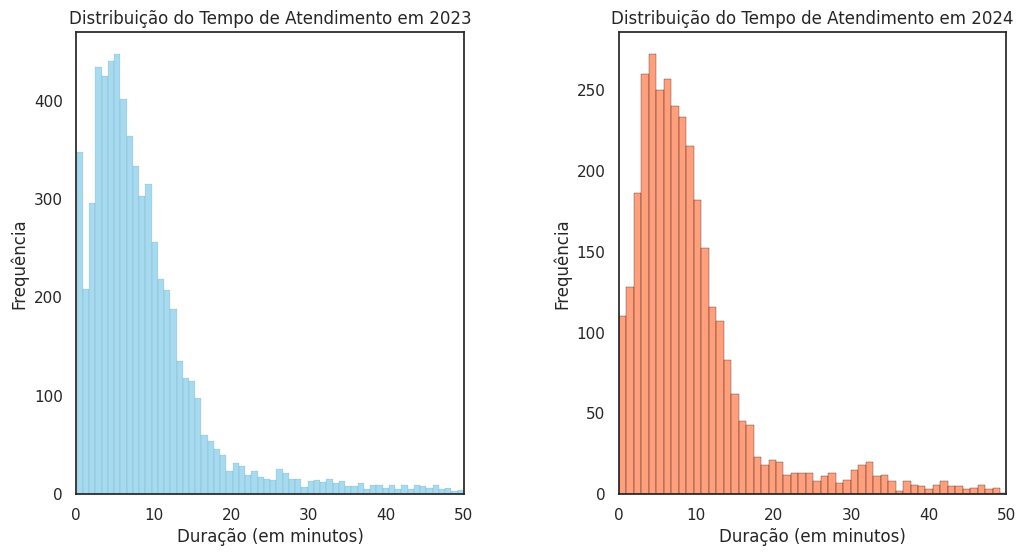

In [37]:
# Assuming your dataframes are named df_a_espera and df_b_espera

# Set the background style (optional)
plt.figure(figsize=(12, 6))  # Adjust figure size for side-by-side plots
sns.set_style("white")  # Optional: Set white background (no grid)

# Plot histograms side-by-side using subplots (similar to method 1 from previous response)
plt.subplot(1, 2, 1)  # First subplot for df_a_espera

sns.histplot(data=df_a_atendimento, x='duracao_tempo_minutes', color='skyblue', edgecolor='black')
plt.title('Distribuição do Tempo de Atendimento em 2023')
plt.xlabel('Duração (em minutos)')
plt.ylabel('Frequência')
plt.xlim(0, 50)  # Adjust x-axis limits based on your data

# Remove gridlines (not needed with white style)
plt.grid(False)

plt.subplot(1, 2, 2)  # Second subplot for df_b_espera

sns.histplot(data=df_b_atendimento, x='duracao_tempo_minutes', color='coral', edgecolor='black')
plt.title('Distribuição do Tempo de Atendimento em 2024')
plt.xlabel('Duração (em minutos)')
plt.ylabel('Frequência')
plt.xlim(0, 50)  # Adjust x-axis limits based on your data

# Optional: Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)  # Adjust spacing as needed

# Save the figure with a descriptive name
plt.savefig('histograma_atendimento_trindade.png')  # Saves as PNG by default

plt.show()  # Optional: Display the plot before saving

In [38]:
# Descriptive analysis segmented by nm_especialidade for df_b_atendimento
print("\nDescriptive statistics for df_b_atendimento segmented by nm_especialidade:")
descriptive_stats_atendimento_segmented = df_b_atendimento.groupby('nm_especialidade')['duracao_tempo_minutes'].describe().round().astype(int)

# Sort by the median (50th percentile)
descriptive_stats_atendimento_segmented_sorted = descriptive_stats_atendimento_segmented.sort_values(by='50%', ascending=True)
descriptive_stats_atendimento_segmented_sorted


Descriptive statistics for df_b_atendimento segmented by nm_especialidade:


,count,mean,std,min,25%,50%,75%,max
nm_especialidade,,,,,,,,
Otorrinolaringologia,119,5,5,0,3,3,5,41
Cardiologia,205,6,4,0,3,5,7,25
Oftalmologia,267,6,6,0,3,5,7,54
Endocrinologia,146,6,6,1,3,5,7,62
Ginecologia e Obstetrícia,453,7,9,0,2,5,8,129
Urologia,52,7,4,2,4,6,8,23
Clinica Médica,523,8,5,0,4,7,10,31
Ortopedia e Traumatologia,219,8,4,2,5,8,10,31
Nutrição,52,9,3,0,7,9,11,17


# Comparação Estatística das Medianas - Teste A/B

In [39]:
# import scipy
# from scipy import stats

# shapiro_wilk = scipy.stats.shapiro

# # Perform the Shapiro-Wilk test
# stat, p_value = shapiro_wilk(df_a_espera['duracao_tempo_minutes'])

# # Interpretation
# if p_value > 0.05:  # Adjust significance level as needed
#   print("The data appears to be normally distributed (Shapiro-Wilk test).")
# else:
#   print("The data appears to be non-normal (Shapiro-Wilk test).")

In [40]:
# # Perform the Shapiro-Wilk test
# stat, p_value = shapiro_wilk(df_b_espera['duracao_tempo_minutes'])

# # Interpretation
# if p_value > 0.05:  # Adjust significance level as needed
#   print("The data appears to be normally distributed (Shapiro-Wilk test).")
# else:
#   print("The data appears to be non-normal (Shapiro-Wilk test).")

In [41]:
# # Perform the Shapiro-Wilk test
# stat, p_value = shapiro_wilk(df_a_atendimento['duracao_tempo_minutes'])

# # Interpretation
# if p_value > 0.05:  # Adjust significance level as needed
#   print("The data appears to be normally distributed (Shapiro-Wilk test).")
# else:
#   print("The data appears to be non-normal (Shapiro-Wilk test).")

In [42]:
# # Perform the Shapiro-Wilk test
# stat, p_value = shapiro_wilk(df_b_atendimento['duracao_tempo_minutes'])

# # Interpretation
# if p_value > 0.05:  # Adjust significance level as needed
#   print("The data appears to be normally distributed (Shapiro-Wilk test).")
# else:
#   print("The data appears to be non-normal (Shapiro-Wilk test).")

In [43]:
# import scipy.stats as stats

# # Hypothesis testing: H0 - medians are similar, H1 - medians in df_b are higher

# # Compare espera (waiting time)
# espera_a_median = df_a_espera['duracao_tempo_minutes'].median()
# espera_b_median = df_b_espera['duracao_tempo_minutes'].median()
# u_espera, p_value_espera = stats.mannwhitneyu(df_a_espera['duracao_tempo_minutes'], df_b_espera['duracao_tempo_minutes'])

# # Compare atendimento (service time)
# atendimento_a_median = df_a_atendimento['duracao_tempo_minutes'].median()
# atendimento_b_median = df_b_atendimento['duracao_tempo_minutes'].median()
# u_atendimento, p_value_atendimento = stats.mannwhitneyu(df_a_atendimento['duracao_tempo_minutes'], df_b_atendimento['duracao_tempo_minutes'])

# # Interpret the results
# print("Espera:")
# if p_value_espera < 0.05:  # Adjust significance level as needed
#     print(f"There is a statistically significant difference (p-value = {p_value_espera:.4f})")
#     if espera_b_median > espera_a_median:
#         print(f"The median waiting time in df_b_espera ({espera_b_median:.2f} minutes) is higher than in df_a_espera ({espera_a_median:.2f} minutes).")
#     else:
#         print("The medians are not significantly different.")
# else:
#     print(f"There is no statistically significant difference in medians (p-value = {p_value_espera:.4f})")

# print("\nAtendimento:")
# if p_value_atendimento < 0.05:  # Adjust significance level as needed
#     print(f"There is a statistically significant difference (p-value = {p_value_atendimento:.4f})")
#     if atendimento_b_median > atendimento_a_median:
#         print(f"The median service time in df_b_atendimento ({atendimento_b_median:.2f} minutes) is higher than in df_a_atendimento ({atendimento_a_median:.2f} minutes).")
#     else:
#         print("The medians are not significantly different.")
# else:
#     print(f"There is no statistically significant difference in medians (p-value = {p_value_atendimento:.4f})")


In [44]:
# # Calculate the medians
# median_b_espera = df_b_espera['duracao_tempo_seconds'].median()
# median_a_espera = df_a_espera['duracao_tempo_seconds'].median()

# # Ensure average_waiting_time_a is positive to avoid division by zero
# if median_a_espera <= 0:
#   print("Median waiting time in df_a_espera cannot be zero or negative for percentage calculation.")
# else:
#   # Calculate percentage difference
#   percentage_difference = ((median_b_espera - median_a_espera) / median_a_espera) * 100

#   # Print the result with formatting
#   print(f"The median waiting time in df_b_espera is approximately {percentage_difference:.2f}% higher than in df_a_espera.")

In [45]:
# # Calculate the medians
# median_b_espera = df_b_espera['duracao_tempo_minutes'].median().round().astype(int)
# median_a_espera = df_a_espera['duracao_tempo_minutes'].median().round().astype(int)

# # Ensure average_waiting_time_a is positive to avoid division by zero
# if median_a_espera <= 0:
#   print("Median waiting time in df_a_espera cannot be zero or negative for percentage calculation.")
# else:
#   # Calculate percentage difference
#   percentage_difference = ((median_b_espera - median_a_espera) / median_a_espera) * 100

#   # Print the result with formatting
#   print(f"The median waiting time in df_b_espera is approximately {percentage_difference:.2f}% higher than in df_a_espera.")

In [46]:
# median_b_espera

In [47]:
# median_a_espera

In [48]:
# df_a_espera.to_excel('espera_a.xlsx', index=False, sheet_name='bd')
# df_a_atendimento.to_excel('atendimento_a.xlsx', index=False, sheet_name='bd')